In [98]:
import numpy as np
import itertools

In [99]:
def get_shapes(any_):
    for array in any_:
        try:
            print(array.shape)
        except:
            print("NONE")
    print("\n")

In [100]:
# ============= ACTIVATION FUNCTIONS ===============#

def sigmoid(Z, prime=False):
    # np.
    if prime:
        return sigmoid(Z) * (1 - sigmoid(Z))
    return 1 / (1 + np.exp(-Z))


def linear(Z, prime=False):
    if prime:
        return np.ones_like(Z)
    return Z


def relu(Z, alpha=0, prime=False):
    if prime:
        Z_relu = np.ones_like(Z, dtype=np.float64)
        Z_relu[Z < 0] = alpha
        return Z_relu
    return np.where(Z < 0, alpha * Z, Z)


def tanh(Z, prime=False):
    # np.tanh() could be used directly to speed this up
    if prime:
        return 1 - np.power(tanh(Z), 2)
    return (2 / (1 + np.exp(-2 * Z))) - 1


def elu(Z, prime=False):
    # https://mlfromscratch.com/activation-functions-explained/#/
    alpha = 0.2
    if prime:
        return np.where(Z < 0, alpha * (np.exp(Z)),1)
    return np.where(Z < 0, alpha * (np.exp(Z) - 1), Z)


def softmax(Z, prime=False):
    if prime:
        return 1
    return np.exp(Z) / np.sum(np.exp(Z),axis=0)

In [101]:
# ============== LOSS FUNCTIONS ===============#

def calculate_error(Y, Y_hat):
    m = Y.shape[1]
    return np.sum(0.5 * np.square(Y - Y_hat)) / m

In [102]:
# References
# https://mc.ai/multilayered-neural-network-from-scratch-using-python/
# https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
# https://www.coursera.org/learn/machine-learning/home/week/5
# https://www.coursera.org/specializations/deep-learning
# https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network.py

class NeuralNetwork:
    

    def __init__(
        self,
        input_layer: tuple,
        hidden_layer: list, # list of tuples
        output_layer: int,
        batch_size: int,
        alpha: float,
        epoch: int,
    ):
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.mini_batch_size = batch_size
        self.alpha = alpha
        self.epoch = epoch
        
        self.m = X.shape[1] # where (no_of_features, no_of_training_examples)
        self.layers = len(self.weight_set_dimensions) + 1


    def calculate_delta_final(self, Y):
        final_act_func = self.activation_functions[-1]
        arg_to_pass_to_eval = "(self.Z[-1], prime=True)"
        
        return (self.A[-1] - Y) * eval(final_act_func + arg_to_pass_to_eval)


    def get_dimensions_and_activations(self):
        self.dimensions = []
        self.activation_functions = []
        
        self.dimensions.append(self.input_layer[0])
        self.activation_functions.append(self.input_layer[1])

        for dim, act_func in self.hidden_layer:
            self.dimensions.append(dim)
            self.activation_functions.append(act_func)

        self.dimensions.append(self.output_layer)

        
    @property
    def weight_set_dimensions(self):
        self.get_dimensions_and_activations()
        a, b = itertools.tee(self.dimensions[::-1])
        next(b, None)
        weight_set_dimensions = list(zip(a, b))[::-1]
        return weight_set_dimensions


    def initialise_weights(self):

        self.W = np.empty_like(range(self.layers), dtype=object)
        self.B = np.empty_like(range(self.layers), dtype=object)
        self.W[0] = None
        self.B[0] = None
        for layer, (y, x) in zip(range(1, self.layers), self.weight_set_dimensions):
            np.random.seed(42)
            self.W[layer] = np.random.rand(y, x)
            self.B[layer] = np.random.rand(y, 1)


    def forwardpass(self, X):
        self.Z = np.empty_like(range(self.layers), dtype=object)
        self.A = np.empty_like(range(self.layers), dtype=object)
        self.A[0] = X
        self.Z[0] = None
        for layer in range(1, self.layers):
            # activation_function starts from 0 whereas layer starts from 1
            active_function = self.activation_functions[layer - 1]
            arg_to_pass_to_eval = "(self.Z[layer])"

            self.Z[layer] = self.W[layer] @ self.A[layer - 1] + self.B[layer]
            self.A[layer] = eval(active_function + arg_to_pass_to_eval)


    def backpropagation(self, Y):
        delta_final = self.calculate_delta_final(Y)
        self.delta = np.empty_like(range(self.layers), dtype=object)
        self.delta[0] = None
        self.delta[-1] = delta_final

        self.gradient_W = np.empty_like(range(self.layers), dtype=object)
        self.gradient_B = np.empty_like(range(self.layers), dtype=object)
        self.gradient_W[0] = None
        self.gradient_B[0] = None
        
        # We substract 1 here as delta_final is calculated seperately above
        for layer in reversed(range(1, self.layers - 1)):
            active_function = self.activation_functions[layer - 1]
            arg_to_pass_to_eval = "(self.Z[layer], prime=True)"

            self.delta[layer] = (
                self.W[layer + 1].T @ self.delta[layer + 1] *
                eval(active_function + arg_to_pass_to_eval)
            ) 
            # E.g. eval part might correspond to -> sigmoid(self.Z[layer], prime=True)

        # calculate the gradient
        for layer in range(1, self.layers):
            self.gradient_W[layer] = (self.delta[layer] @ self.A[layer - 1].T) / self.m
            self.gradient_B[layer] = np.sum(self.delta[layer], axis=1, keepdims=True) / self.m

        #update the weights
        for layer in range(1, self.layers):
            self.W[layer] -= self.alpha * self.gradient_W[layer]
            self.B[layer] -= self.alpha * self.gradient_B[layer]
            
            
    def fit(self, X, Y):
        self.initialise_weights()
        
        # By default the method is SGD(Stochastic Gradient Descent) if one wishes to use
        # the whole batch, simply pass the number of traning examples available as the
        # batch size when instantiating the class
        self.no_of_iterations = 0
        shuffled = np.arange(self.m)
        for epoch_no in range(1, self.epoch + 1):
            np.random.shuffle(shuffled)
            X = X[:, shuffled]
            Y = Y[:, shuffled]
            for i in range(0, self.m, self.mini_batch_size):
                self.no_of_iterations += 1
                X_mini_batch = X[:, i: i + self.mini_batch_size]
                Y_mini_batch = Y[:, i: i + self.mini_batch_size]
                self.forwardpass(X_mini_batch)
                self.backpropagation(Y_mini_batch)
                if self.no_of_iterations % 5000 == 0:
                    print("iteration %s - loss %.20f" %(self.no_of_iterations, calculate_error(Y_mini_batch, self.A[-1])))


    def predict(self, X):
        self.forwardpass(X)

        return np.argmax(self.A[-1].T, axis=1)

# Testing with benchmark datasets

## 1.Iris Dataset

In [103]:
from sklearn.datasets import load_iris
data = load_iris()
X = data.data[:,[0,2]].T
y = data.target
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y = lb.fit_transform(y)
Y = Y.T

In [104]:
print(X.shape)
print(Y.shape)

(2, 150)
(3, 150)


In [105]:
self = NeuralNetwork(
    input_layer=(2, "tanh"),
    hidden_layer=[(6, "tanh"),(4, "sigmoid")],
    output_layer=3,
    batch_size=64,
    alpha=0.5,
    epoch=5000
)

self.fit(X, Y)

iteration 5000 - loss 0.18999082351379142919
iteration 10000 - loss 0.14681789349572352266
iteration 15000 - loss 0.00730931442046636130


In [106]:
self.predict(X) == np.argmax(Y, axis=0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True,

Text(0, 0.5, 'petal length')

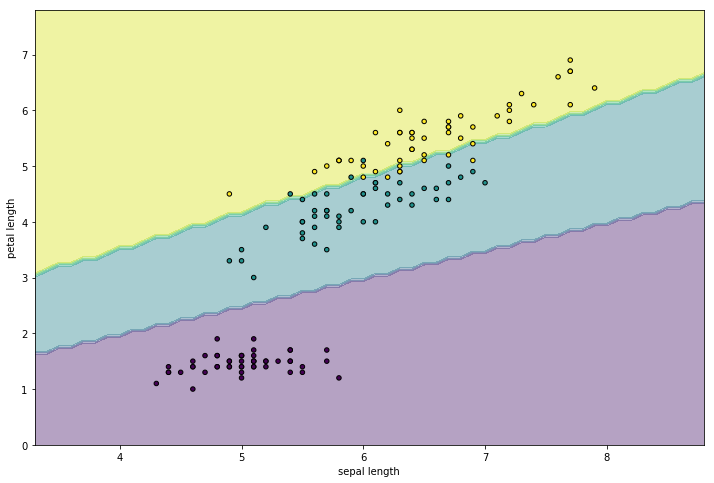

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,2]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = self.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.xlabel('sepal length')
plt.ylabel('petal length')

## 2.Make Moons dataset

In [11]:
from sklearn.datasets import make_moons
from sklearn import preprocessing

x,y =make_moons(n_samples=1500, noise=.05)
X = x.T
lb = preprocessing.LabelBinarizer()
Y = lb.fit_transform(y)
y_next = np.where(y==0,1,0)
Y = Y.T
Y = list(Y)
Y.append(y_next)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(2, 1500)
(2, 1500)


In [12]:
model = NeuralNetwork(
    input_layer=(2, "tanh"),
    hidden_layer=[(6, "tanh"),(4, "sigmoid")],
    output_layer=2,
    alpha=0.5,
    no_of_iterations=50000
)

model.fit(X, Y)

iteration 0 - loss 0.41846039821716152218
iteration 2500 - loss 0.00065953837205494760
iteration 5000 - loss 0.00024434612442749424
iteration 7500 - loss 0.00014796519968299172
iteration 10000 - loss 0.00010580488157657664
iteration 12500 - loss 0.00008226886171104454
iteration 15000 - loss 0.00006727753000328104
iteration 17500 - loss 0.00005690192706204753
iteration 20000 - loss 0.00004929825528360425
iteration 22500 - loss 0.00004348806712897885
iteration 25000 - loss 0.00003890440488073269
iteration 27500 - loss 0.00003519625899136302
iteration 30000 - loss 0.00003213477666534354
iteration 32500 - loss 0.00002956441436053350
iteration 35000 - loss 0.00002737577966803619
iteration 37500 - loss 0.00002548970672302766
iteration 40000 - loss 0.00002384749631332809
iteration 42500 - loss 0.00002240470645148460
iteration 45000 - loss 0.00002112707331216811
iteration 47500 - loss 0.00001998775626889631
iteration 50000 - loss 0.00001896543149490028


Text(0.5, 1.0, 'Decision Boundaries')

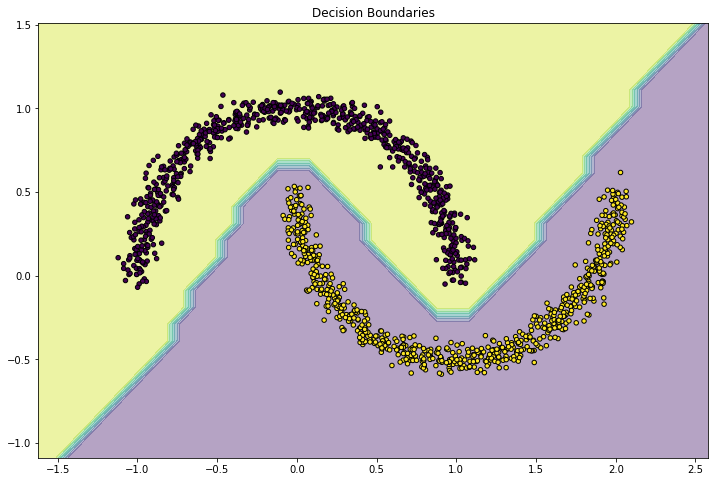

In [13]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 0.5, dt[:, 0].max() + 0.5
y_min, y_max = dt[:, 1].min() - 0.5, dt[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.title('Decision Boundaries')

In [14]:
model.B[3]

array([[-0.18715018],
       [ 0.3333697 ]])

## 3.Andrew NG Assignment 2 Dataset

In [16]:
ex2data2 = np.loadtxt("/home/cagri/Desktop/Google Drive/data/ex2data2.txt", delimiter=",")

X = ex2data2[:, :-1]
y = ex2data2[:, -1].reshape(-1, 1)

dt = np.c_[X, y]

X = X.T
Y = y.T

OSError: /home/cagri/Desktop/Google Drive/data/ex2data2.txt not found.

In [ ]:
model = NeuralNetwork(
    input_layer=(2, "sigmoid"),
    hidden_layer=[(2, "sigmoid")],
    output_layer=2,
    alpha=0.5,
    no_of_iterations=150000
)

model.fit(X, Y)

In [ ]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
X = ex2data2

x1_min, x1_max = X[:, 0].min() - 0.3, X[:, 0].max() + 0.3,
x2_min, x2_max = X[:, 1].min() - 0.3, X[:, 1].max() + 0.3,
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()].T) 

negatives = ex2data2[ex2data2[:, -1] == 0]
positives = ex2data2[ex2data2[:, -1] == 1]

# Put the result into a color plot
Z = Z.reshape(xx1.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx1, xx2, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(negatives[:, 0], negatives[:, 1],s=50, edgecolor='k')
plt.scatter(positives[:, 0], positives[:, 1],s=50, edgecolor='b')
plt.title('Decision Boundaries')

plt.contour(xx1, xx2, Z, [0.5], linewidths=2, colors="g")

In [ ]:
get_shapes(model.gradient_W)

In [ ]:
class NeuralNetwork:
    

    def __init__(
        self,
        input_layer: tuple,
        hidden_layer: list, # list of tuples
        output_layer: int,
        alpha: float,
        no_of_iterations: int,
    ):
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.alpha = alpha
        self.no_of_iterations = no_of_iterations
        
        self.m = X.shape[1] # where (no_of_features, no_of_training_examples)
        self.layers = len(self.weight_set_dimensions)


    def calculate_delta_final(self, Y):
        final_act_func = self.activation_functions[-1]
        arg_to_pass_to_eval = "(self.Z[-1], prime=True)"
        
        return (self.A[-1] - Y) * eval(final_act_func + arg_to_pass_to_eval)


    def get_dimensions_and_activations(self):
        self.dimensions = []
        self.activation_functions = []
        
        self.dimensions.append(self.input_layer[0])
        self.activation_functions.append(self.input_layer[1])

        for dim, act_func in self.hidden_layer:
            self.dimensions.append(dim)
            self.activation_functions.append(act_func)

        self.dimensions.append(self.output_layer)

        
    @property
    def weight_set_dimensions(self):
        self.get_dimensions_and_activations()
        a, b = itertools.tee(self.dimensions[::-1])
        next(b, None)
        weight_set_dimensions = list(zip(a, b))[::-1]
        return weight_set_dimensions


    def initialise_weights(self):

        self.W = np.empty_like(range(self.layers + 1), dtype=object)
        self.B = np.empty_like(range(self.layers + 1), dtype=object)
        self.W[0] = None
        self.B[0] = None
        # self.parameters = {}
        for layer, (y, x) in zip(range(self.layers), self.weight_set_dimensions):
            np.random.seed(42)
            self.W[layer + 1] = np.random.rand(y, x)
            self.B[layer + 1] = np.random.rand(y, 1)
#             self.parameters["W" + str(layer)] = np.random.rand(row, column)
#             self.parameters["B" + str(layer)] = np.random.rand(row, 1)


    def forwardpass(self, X):
#         self._params = {}
#         self._params["A0"] = X
        self.Z = np.empty_like(range(self.layers + 1), dtype=object)
        self.A = np.empty_like(range(self.layers + 1), dtype=object)
        self.A[0] = X
        self.Z[0] = None
        for layer in range(self.layers):
            # activation_function starts from 0 whereas layer starts from 1
            active_function = self.activation_functions[layer]
            arg_to_pass_to_eval = "(self.Z[layer + 1])"

            self.Z[layer + 1] = self.W[layer + 1] @ self.A[layer] + self.B[layer + 1]
            self.A[layer + 1] = eval(active_function + arg_to_pass_to_eval)

#             arg_to_pass_to_eval = "(self._params['Z' + str(layer)])"
#             self._params["Z" + str(layer)] = (self.parameters["W" + str(layer)] @
#                                               self._params["A" + str(layer - 1)] +
#                                               self.parameters["B" + str(layer)])
#             self._params["A" + str(layer)] = eval(active_function + arg_to_pass_to_eval)

    def backpropagation(self, Y):
        delta_final = self.calculate_delta_final(Y)
        self.delta = np.empty_like(range(self.layers + 1), dtype=object)
        self.delta[0] = None
        self.delta[-1] = delta_final

        self.gradient_W = np.empty_like(range(self.layers + 1), dtype=object)
        self.gradient_B = np.empty_like(range(self.layers + 1), dtype=object)
        self.gradient_W[0] = None
        self.gradient_B[0] = None

        # here Z[index+1] is passed instead of Z[index] this is because Z[0] is none.
        # So Z[index+1] is effectively Z[index].

        for layer in reversed(range(1, self.layers)):
            active_function = self.activation_functions[layer]
            arg_to_pass_to_eval = "(self.Z[layer], prime=True)"

            self.delta[layer] = (
                self.W[layer + 1].T @ self.delta[layer + 1] *
                eval(active_function + arg_to_pass_to_eval)
            )

        # calculate the gradient
        for layer in range(self.layers):
            self.gradient_W[layer + 1] = (self.delta[layer + 1] @ self.A[layer].T) / self.m
            self.gradient_B[layer + 1] = np.sum(self.delta[layer + 1], axis=1, keepdims=True) / self.m

        #update the weights
        for layer in range(self.layers):
            self.W[layer+1] -= self.alpha * self.gradient_W[layer+1]
            self.B[layer+1] -= self.alpha * self.gradient_B[layer+1]
            
            
    def fit(self, X, Y):
        self.initialise_weights()
        
        for iteration in range(self.no_of_iterations + 1):
            self.forwardpass(X)
            self.backpropagation(Y)
            if iteration % 100 == 0 or iteration == self.no_of_iterations:
                print("iteration %s - loss %.20f" %(iteration, calculate_error(Y, self.A[-1])))


    def predict(self, X):
        self.forwardpass(X)

        return np.argmax(self.A[-1].T, axis=1)

In [2]:
list(range(1,35, 16))

[1, 17, 33]

In [7]:
import numpy as np

In [8]:
X.shape

(2, 150)

In [23]:
y = y.reshape(1, 150)

In [26]:
for epoch_no in range(1, 500):
    np.random.shuffle(idx)
    X = X[:,idx]
    y = y[:,idx]
    for i in range(0,150, 16):
        X_batch = X[:,i:i + 16]
        print(i, X_batch.shape)
        y_batch = y[:,i:i + 16]

0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0

96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
9

0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0

80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)
0 (2, 16)
16 (2, 16)
32 (2, 16)
48 (2, 16)
64 (2, 16)
80 (2, 16)
96 (2, 16)
112 (2, 16)
128 (2, 16)
144 (2, 6)


In [10]:
idx = np.arange(0,X.shape[1])

In [12]:
idx

(150,)

In [13]:
np.random.shuffle(idx)

In [15]:
X = X[:,idx]

In [16]:
X

array([[4.7, 6.4, 6.5, 5. , 5.7, 7. , 6.2, 5. , 5.5, 6. , 4.3, 6.2, 5.8,
        5.7, 6.3, 5.9, 5.3, 5.1, 5.7, 5. , 5. , 7.3, 6.5, 6.6, 6.7, 6.7,
        5.6, 6.4, 5.5, 6.3, 4.9, 4.9, 5.8, 5.7, 5.8, 5.2, 5.1, 7.7, 6.5,
        6.8, 7.2, 6.5, 6.7, 7.2, 5.1, 6.2, 6.3, 6. , 4.6, 4.8, 6.1, 5.6,
        4.8, 4.6, 5.7, 6.1, 6.3, 6.4, 5.8, 5.1, 5.7, 6.9, 4.9, 4.7, 6.3,
        5.1, 5.8, 5. , 5.4, 4.8, 5. , 6. , 5.5, 6.6, 6.3, 6.1, 4.4, 6.4,
        6.4, 5.2, 5.7, 7.2, 4.5, 6.3, 5.2, 5. , 5.6, 5. , 5.1, 4.6, 6.4,
        5.4, 6.7, 6.1, 5.4, 6.3, 6.8, 5.8, 6. , 7.4, 6.7, 6. , 5. , 6.8,
        5.9, 7.1, 5.6, 4.4, 5.9, 6.7, 6.1, 4.9, 5.5, 5.1, 6.9, 7.6, 4.8,
        5.5, 6.9, 5.4, 5.5, 7.7, 5.1, 4.4, 6.5, 6. , 7.9, 6.2, 7.7, 4.8,
        5.2, 5.7, 5.6, 6.7, 4.9, 6.7, 6.4, 5.4, 5.5, 5.4, 6.3, 5.8, 5.6,
        7.7, 5. , 4.9, 4.6, 5.1, 6.1, 6.9],
       [1.3, 5.6, 5.2, 1.3, 4.1, 4.7, 4.5, 1.4, 4. , 4. , 1.1, 4.8, 3.9,
        1.7, 5.1, 4.2, 1.5, 1.6, 3.5, 3.3, 1.6, 6.3, 5.5, 4.6, 4.4, 5.7,
       